# k-means

The $k$-means algorithm is one of the best-known and most widely used clustering methods, although it has some serious limitations and drawbacks. 

Given a sample matrix $\bfX$ with $n$ rows $\bfx_i$, the algorithm divides the sample points into disjoint sets $C_1,\ldots,C_k$, where $k$ is a preselected hyperparameter. Cluster $j$ has a **centroid** $\bfmu_j$, which is the mean of the points in $C_j$. Define the **inertia** of $C_j$ as 

$$
I_j = \sum_{\bfx\in C_j} \norm{ \bfx - \bfmu_j }_2^2.
$$

The goal of the algorithm is to choose the clusters in order to minimize the total inertia,

$$
I = \sum_{j=1}^k I_j.
$$

<!-- For any cluster, its centroid is the point that minimizes the inertia of the cluster. Suppose that $C_j$ is split into two parts $A$ and $B$ that have centroids $\bfmu_A$ and $\bfmu_B$. Those centroids minimize the inertias of the subclusters. Hence, 

$$
\sum_{\bfx\in A} \norm{ \bfx - \bfmu_A }^2 + \sum_{\bfx\in B} \norm{ \bfx - \bfmu_B }^2 
\le  \sum_{\bfx\in A} \norm{ \bfx - \bfmu_j }^2 + \sum_{\bfx\in B} \norm{ \bfx - \bfmu_j}^2  = I_j. 
$$

We conclude that splitting a cluster will make the total inertia decrease. In fact, if each sample point is put into its own cluster, the inertia is 0.  -->

::::{prf:example}
:label: example-k-means-inertia
Let $k=2$. Given the values $-3,-2,-1,2,5,7$, we might cluster $\{-3,-2,-1\}$ and $\{2,5,7\}$. The total inertia is then

$$
\left[  (-3+2)^2 + (-2+2)^2 + (-1+2)^2   \right]  + \left[  \bigl(2-\tfrac{14}{3}\bigr)^2 + \bigl(5-\tfrac{14}{3}\bigr)^2 + \bigl(7-\tfrac{14}{3}\bigr)^2   \right] = 2 + \frac{124}{9} = 15.78.
$$

If we instead cluster as $\{-3,-2,-1,2\}$ and $\{5,7\}$, then the total inertia is 

$$
\left[  (-3+1)^2 + (-2+1)^2 + (-1+1)^2  + (2+1)^2 \right]  + \left[   (5-6)^2 + (7-6)^2   \right] = 14 + 2 = 16.
$$
::::

Finding the minimum inertia among all possible $k$-clusterings is an infeasible problem to solve exactly at any practical size. Instead, the approach is to iteratively improve from a starting clustering.

## Lloyd's algorithm

The standard method is known as **Lloyd's algorithm**. Starting with values for the $k$ centroids, there is an iteration consisting of two steps:

* **Assignment** Each sample point is assigned to the cluster whose centroid is the nearest. (Ties are broken randomly.)
* **Update** Recalculate the centroids based on the cluster assignments:

$$
\bfmu_j^+ = \frac{1}{|C_j|} \sum_{\bfx\in C_j} \bfx.
$$

The algorithm stops when the assignment step does not change any of the clusters. In practice, this almost always happens quickly. Here is a demonstration:

```{raw} html
<video width=640 controls src="../_static/kmeans_demo.mp4"></video>
```

While Lloyd's algorithm will find a local minimum of total inertia, in the sense that small changes cannot decrease it, there is no guarantee of converging to the global minimum.

## Practical issues

* **Initialization**. The performance of $k$-means depends a great deal on the initial set of centroids. Traditionally, the centroids were chosen as random members of the sample set, but better/more reliable heuristics, such as *$k$-means++*, have since become more dominant. 
* **Multiple runs**. All the initialization methods include an element of randomness, and since the Lloyd algorithm usually converges quickly, it is often run with multiple instances of the initialization, and the run with the lowest inertia is kept.
* **Selection of $k$**. The algorithm treats $k$ as a hyperparameter. Occam's Razor dictates preferring smaller values to large ones. There are many suggestions on how to find the choice that gives the most "bang for the buck."
* **Distance metric**. The Lloyd algorithm often fails to converge for norms other than the 2-norm, and must be modified if another norm is preferred.
* **Shape effects**. Because of the dependence on the norm, the inertia criterion disfavors long, skinny clusters and clusters of unequal dispersion. Basically, it wants to find spherical blobs (as defined by the metric) of roughly equal size.

## Toy example

Let's regenerate the blobs from the previous section.

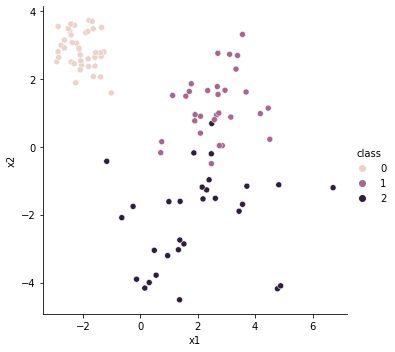

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_blobs
X,y = make_blobs(
    n_samples=[40,30,30],
    centers=[[-2,3],[3,1.5],[2,-2]],
    cluster_std=[0.5,0.9,1.5],
    random_state = 19716
    )
blobs = pd.DataFrame({"x1":X[:,0],"x2":X[:,1],"class":y})
sns.relplot(data=blobs,x="x1",y="x2",hue="class");

Now we try $k$-means with $k=3$.

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=3)
km.fit(X)

blobs["km3"] = km.predict(X)
blobs.head(8)

,x1,x2,class,km3
0,1.328556,-3.036395,2,2
1,-1.815547,2.585740,0,1
2,3.387517,2.686224,1,0
3,2.348428,1.652876,1,0
4,-1.266983,2.792976,0,1
5,2.489843,0.682657,2,0
6,1.775981,1.854831,1,0
7,2.702074,2.752115,1,0


Here we show the points using color to indicate cluster membership and size for the silhouette value:

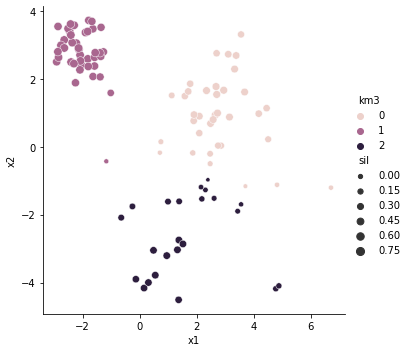

In [3]:
blobs["sil"] = silhouette_samples(X,blobs["km3"])
sns.relplot(data=blobs,x="x1",y="x2",hue="km3",size=blobs["sil"]);

Intuitively, this is at least comparable to the original classification. The silhouettes show a modest reduction for the better clusters, but improvement for the problematic one.

In [4]:
print("scores for original classes:")
print(blobs.groupby("class")["sil"].mean().sort_values())

print("\nscores for 3 k-means clusters:")
print(blobs.groupby("km3")["sil"].mean().sort_values())

scores for original classes:
class
2    0.364877
1    0.537780
0    0.810844
Name: sil, dtype: float64

scores for 3 k-means clusters:
km3
2    0.401121
0    0.493170
1    0.793501
Name: sil, dtype: float64


What happens when we ask for just $k=2$ clusters?

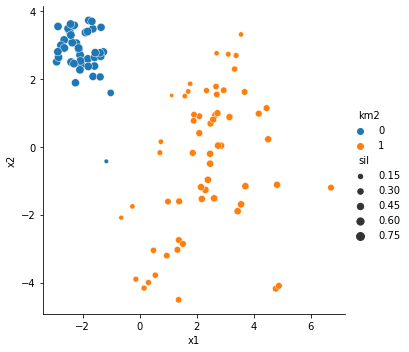

In [5]:
km = KMeans(n_clusters=2)
km.fit(X)

blobs["km2"] = km.predict(X)
blobs["sil"] = silhouette_samples(X,blobs["km2"])
sns.relplot(data=blobs,x="x1",y="x2",hue="km2",size=blobs["sil"]);

This result is arguably superior to the reference classification.

In [6]:
print("scores for 2 k-means clusters:")
blobs.groupby("km2")["sil"].mean().sort_values()

scores for 2 k-means clusters:


km2
1    0.456869
0    0.813098
Name: sil, dtype: float64

The outlier points in the generated blobs are perhaps best seen as noisy examples, at least for the purposes of clustering. 

## Case study: digits

We can return to the handwriting recognition dataset. Again we keep only the samples labeled 4, 5, or 6.

In [7]:
from sklearn import datasets
digits = datasets.load_digits(as_frame=True)["frame"]
keep = digits["target"].isin([4,5,6])
digits = digits[keep]

X = digits.drop("target",axis="columns")
y = digits["target"]

We fit 3 clusters to the feature matrix:

In [8]:
km = KMeans(n_clusters=3)
km.fit(X)
digits["kmeans3"] = km.predict(X)
digits[["target","kmeans3"]].head(8)

,target,kmeans3
4,4,2
5,5,1
6,6,0
14,4,2
15,5,1
16,6,0
24,4,2
25,5,1


The adjusted Rand index suggests that we have reproduced the classification well:

In [9]:
from sklearn.metrics import adjusted_rand_score
ARI = adjusted_rand_score(y,digits["kmeans3"])
print("ARI:",ARI)

ARI: 0.9617847446531459


However, that conclusion benefits from our prior knowledge. What if we did not know how many clusters to look for? One option is to try many different values of $k$, keeping track of some metric. Here, we record the final total inertia and the mean silhouette score.

In [10]:
from sklearn.metrics import silhouette_score
results = pd.DataFrame({"k":[],"inertia":[],"mean silhouette":[]})
for k in range(2,9):
    km = KMeans(n_clusters=k)
    km.fit(X)

    I = km.inertia_
    sil = silhouette_score(X,km.predict(X))
    results = results.append(pd.DataFrame({"k":[k],"inertia":[I],"mean silhouette":[sil]}),ignore_index=True)
results

,k,inertia,mean silhouette
0,2.0,446601.467620,0.226800
1,3.0,360547.755566,0.251904
2,4.0,325210.020058,0.245860
3,5.0,297558.275700,0.234854
4,6.0,280563.005048,0.188237
5,7.0,269773.137148,0.169136
6,8.0,259294.113156,0.186038


The inertia continues to decrease as $k$ increases, although the rate of decrease slows somewhat. But the silhouette score is maximized at $k=3$, which could be considered a reason to choose 3 clusters.